# Tutorial: applying space motion

The `Optics.image` function can handle an observation time. The loci of sources are propagated to the observation epoch, when the proper motions and parallaxes are properly defined. The `Optics.image` function calculates the positional shift due to parallaxes and optical abbretion. This notebook demonstrates the behavior of the function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from warpfield.telescope import SourceTable
from warpfield.telescope import get_jasmine

from astropy.coordinates import SkyCoord, Angle
from astropy.table import QTable
from astropy.time import Time
import astropy.units as u


from erfa import ErfaWarning
import warnings
warnings.simplefilter('ignore', category=ErfaWarning)

Here, we define two artificial objects at the location of M2. The parallaxes the objects are 1 arcsec and 1 &mu;as, respectively. The proper motions are $(\mu_{\alpha\star}, \mu_\delta) = (50\,\mathrm{mas/year}, 0\,\mathrm{mas/year})$. The epochs are J2016.0 in the TCB scale, the nominal epoch of the Gaia DR3 catalog.

In [2]:
pointing = SkyCoord.from_name('M2').galactic
position_angle = Angle(0.0 * u.deg)

source = SourceTable(QTable([
    [0, 1],
    [pointing.icrs.ra] * 2,
    [pointing.icrs.dec] * 2,
    [5e3 * u.mas / u.year] * 2,
    [0 * u.mas / u.year] * 2,
    [1e3 * u.mas, 1 * u.uas],
    [2016.0 * u.year] * 2,
], names=[
    'source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'ref_epoch'
]))
source.table

source_id,ra,dec,pmra,pmdec,parallax,ref_epoch
,deg,deg,mas / yr,mas / yr,mas,yr
int64,float64,float64,float64,float64,float64,float64
0,323.362583,-0.8232499999999833,5000.0,0.0,1000.0,2016.0
1,323.362583,-0.8232499999999833,5000.0,0.0,0.001,2016.0


The time grid is defined for 3 years. Define a telescope for observation. The telescope is pointed toward M31.

In [3]:
epoch = Time(2016.0, format='decimalyear', scale='tcb')
obstime = epoch + np.linspace(0, 3, 101)*u.year

jasmine = get_jasmine(pointing, position_angle)

Use `apply_space_motion` to propagate the proper motion. Illustrate the motion of the object.

In [4]:
proj = jasmine.optics.projection
posA = QTable(names=['x','y','obstime'])
posB = QTable(names=['x','y','obstime'])

for t in obstime:
    pos = jasmine.optics.imaging(source, epoch=t)
    posA.add_row(pos['x','y','obstime'][0])
    posB.add_row(pos['x','y','obstime'][1])

/home/rohsawa/.pyenv/versions/3.11.10/envs/jasmine/lib/python3.11/site-packages/astropy/table/table.py:3220: UserWarning: Units from inserted quantities will be ignored.
If you were hoping to fill a QTable row by row, also initialize the units before starting, for instance
QTable(names=['x', 'y', 'obstime'], units=['um', 'um', 'yr'])
  self.insert_row(len(self), vals, mask)


The following cell illustrates the motion of the first object. The blue line shows the trace of the first object on the focal plane. The orange dot illustrates the center of the focal plane, the ICRS position at J2016.0. The elliptic shape corresponds to the annual abberation effect, not to the parallax motion. The ellipses are displaced due to the proper motion.

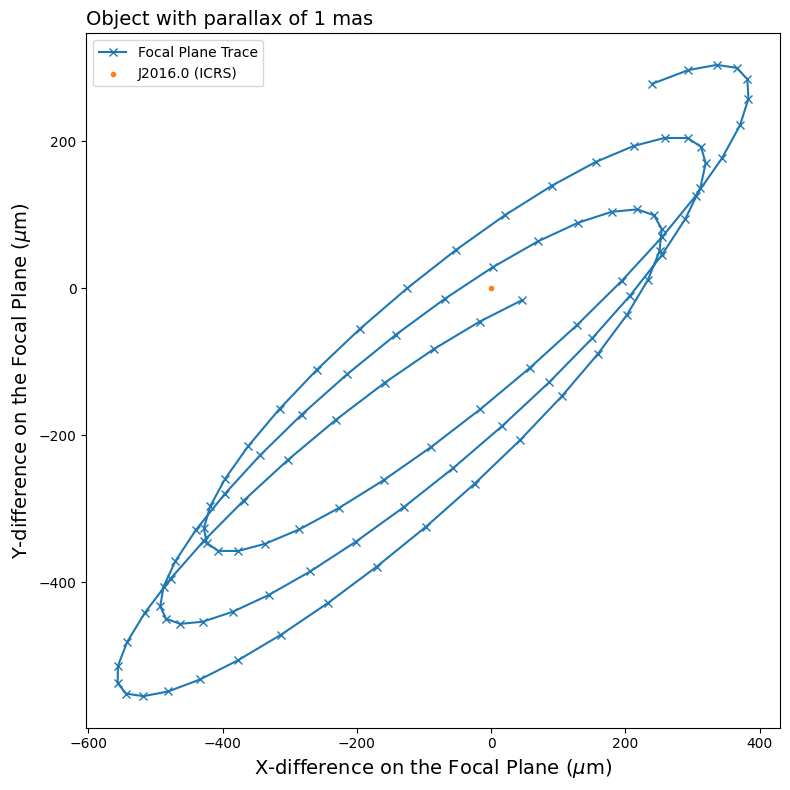

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(posA['x'], posA['y'],
    color='C0',marker='x', label='Focal Plane Trace')
ax.scatter(0.0, 0.0,
    color='C1', marker='.', label='J2016.0 (ICRS)')

ax.legend(loc='upper left')
ax.set_xlabel('X-difference on the Focal Plane ($\mu$m)', fontsize=14)
ax.set_ylabel('Y-difference on the Focal Plane ($\mu$m)', fontsize=14)
ax.set_title('Object with parallax of 1 mas', loc='left', fontsize=14)
fig.tight_layout()
plt.show()

The following cell illustrates the transisions of the focal plane positions. The periodic changes are attributed to the annual abberation effect. The proper motion produces the overall trends.

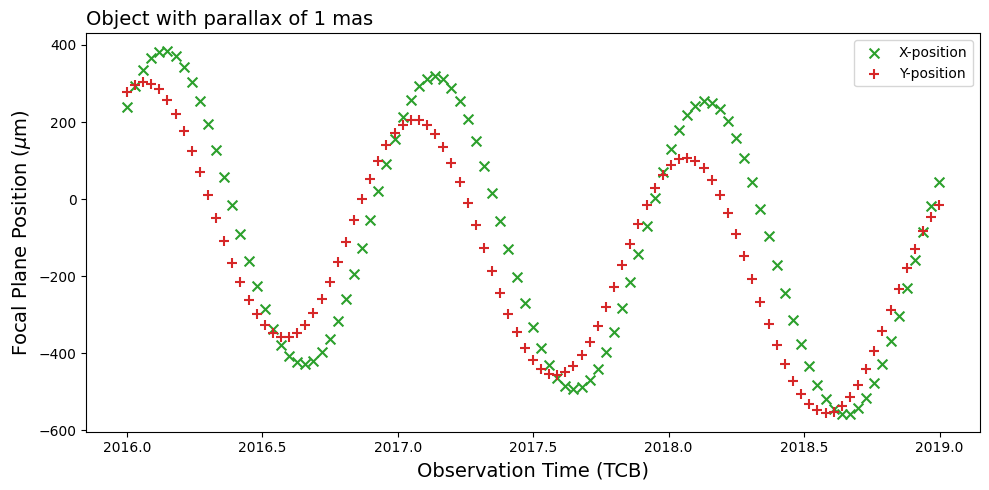

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(posA['obstime'], posA['x'],
    s=50, color='C2', marker='x', label='X-position')
ax.scatter(posA['obstime'], posA['y'],
    s=50, color='C3', marker='+', label='Y-position')

ax.legend(loc='upper right')
ax.set_xlabel('Observation Time (TCB)', fontsize=14)
ax.set_ylabel('Focal Plane Position ($\mu$m)', fontsize=14)
ax.set_title('Object with parallax of 1 mas', loc='left', fontsize=14)
fig.tight_layout()
plt.show()

The parallax of the second object is almost zero. Thus, the positional difference between the first and second objects reflects the parallax motion of the first object. The following cell shows the trace of the difference by the blue line. The elliptical shape is attributed to the parallax. The size of the ellipse is estimated as:

$$
 1'' / 426 \mathrm{mas/pix} \times 10 \mathrm{\mu m/pix} \sim 23.474 \mathrm{\mu m}.
$$

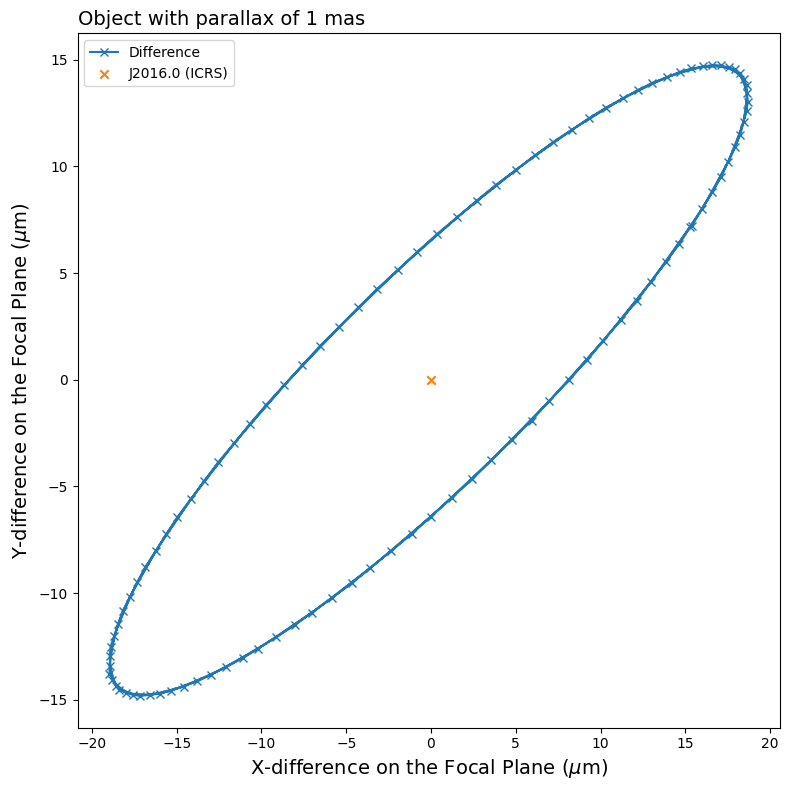

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(posA['x'] - posB['x'], posA['y'] - posB['y'],
    color='C0',marker='x', label='Difference')
ax.scatter(0.0, 0.0,
    color='C1', marker='x', label='J2016.0 (ICRS)')

ax.legend(loc='upper left')
ax.set_xlabel('X-difference on the Focal Plane ($\mu$m)', fontsize=14)
ax.set_ylabel('Y-difference on the Focal Plane ($\mu$m)', fontsize=14)
ax.set_title('Object with parallax of 1 mas', loc='left', fontsize=14)
fig.tight_layout()
plt.show()